# Leapfrog integrator

Goal - implement the symplectic leapfrom integrator with a few test cases. Compare to Euler and Runga-Kutta


We assume we are numerically integration differential equations of the form:
$$
\frac{d^{2}\vec{x}}{dt^{2}} = A(\vec{x})  \iff \begin{cases}
 \frac{dv}{dt} =A(x) \\
\frac{dx}{dt} = v
\end{cases}
$$

The algorithm then proceeds as:


$$
\begin{align}
a_i &=  A(x_i) \\
v_{i+ 1 /2} &=  v_{i - 1 /2} \,\,+a_i \Delta t \\
x_{i+1} &=  x_i\quad \quad  + v_{i+ 1 /2} \Delta t
\end{align}
$$

the temporary variable $a_i$ here is the acceleration (or second derivative of x at step $i$)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# include trajectory history for now
def leapfrog_history(x0, v0, A, dt, num_steps):
    '''implementing the kick-drift-kick form (need dt const)'''
    
    dim = x0.shape[0]
    
    x_history = np.zeros((num_steps, dim))  # Include initial state
    v_history = np.zeros((num_steps, dim))
    
    x = x0.copy()
    v = v0.copy()
    
    for i in range(num_steps):
        a_i = A(x)

        v_half = v + a_i * dt / 2
        x_new = x + v_half * dt
        
        a_new = A(x_new)
        
        v_new = v_half + a_new * dt / 2
        
        # update values
        x = x_new
        v = v_new
        x_history[i] = x
        v_history[i] = v
    
    return x_history, v_history


# compare with the implicit Euler method
def euler_history(x0, v0, A, dt, num_steps):
    dim = x0.shape[0]
    
    x_history = np.zeros((num_steps, dim))
    v_history = np.zeros((num_steps, dim))

    x = x0.copy()
    v = v0.copy()
    
    for i in range(num_steps):
        v_new = v + A(x) * dt
        x_new = x + v * dt
        
        x = x_new
        v = v_new

        x_history[i] = x
        v_history[i] = v

    return x_history, v_history

Let us now try and compare these approaches for a gravity problem:
$$
\frac {\partial \vec x} {\partial t} = - \frac {\vec x} {|\vec x|^3}
$$

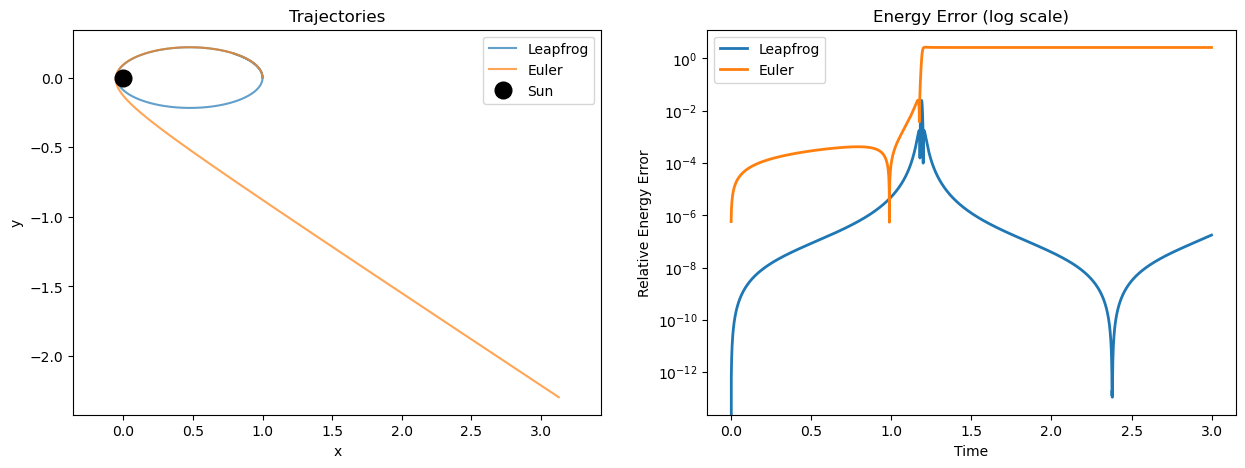

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def A(x):
    r = np.linalg.norm(x)
    return -x / r**3

def compute_energy(xs, vs):
    """Compute total energy (kinetic + potential) for gravitational system"""
    energies = []
    for x, v in zip(xs, vs):
        r = np.linalg.norm(x)
        kinetic = 0.5 * np.dot(v, v)
        potential = -1.0 / r  
        energies.append(kinetic + potential)
    return np.array(energies)

# Initial conditions
x0 = np.array([1.0, 0.0])
v0 = np.array([0.0, 0.3])
dt = 0.001
num_steps = 3000


xs_leapfrog, vs_leapfrog = leapfrog_history(x0, v0, A, dt, num_steps)
xs_euler, vs_euler = euler_history(x0, v0, A, dt, num_steps)

energy_leapfrog = compute_energy(xs_leapfrog, vs_leapfrog)
energy_euler = compute_energy(xs_euler, vs_euler)

time = np.arange(num_steps) * dt

plt.figure(figsize=(15, 5))

# Plot 1: Trajectories
plt.subplot(1, 2, 1)
plt.plot(xs_leapfrog[:, 0], xs_leapfrog[:, 1], label='Leapfrog', alpha=0.7)
plt.plot(xs_euler[:, 0], xs_euler[:, 1], label='Euler', alpha=0.7)
plt.plot(0, 0, 'o', color='black', markersize=12, label='Sun')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories')
plt.legend()
plt.axis('equal')

# Plot 3: Energy error (relative to initial energy)
plt.subplot(1, 2, 2)
E0 = energy_leapfrog[0]
plt.semilogy(time, np.abs((energy_leapfrog - E0) / E0), label='Leapfrog', linewidth=2)
plt.semilogy(time, np.abs((energy_euler - E0) / E0), label='Euler', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Relative Energy Error')
plt.title('Energy Error (log scale)')
plt.legend()

## Hamiltonian System

In [10]:
def leapfrog_history(q0, p0, dt, num_steps, q_dot, p_dot):
    dim = q0.shape[0]
    
    q_history = np.zeros((num_steps, dim))  # Include initial state
    p_history = np.zeros((num_steps, dim))
    
    q = q0.copy()
    p = p0.copy()
    
    for i in range(num_steps):
        p_half = p + p_dot(q) * dt / 2

        q_new = q + q_dot(p_half) * dt
        
        p_new = p_half + p_dot(q_new) * dt / 2
        
        # update values
        q = q_new
        p = p_new

        q_history[i] = q
        p_history[i] = p
    
    return q_history, p_history

def euler_history(q0, p0, dt, num_steps, q_dot, p_dot):
    dim = q0.shape[0]
    
    q_history = np.zeros((num_steps, dim))
    p_history = np.zeros((num_steps, dim))

    q = q0.copy()
    p = p0.copy()
    
    for i in range(num_steps):
        p_new = p + p_dot(q) * dt
        q_new = q + q_dot(p) * dt
        
        q = q_new
        p = p_new

        q_history[i] = q
        p_history[i] = p

    return q_history, p_history

Let us take a *bead on a hoop* problem (with $m=R=g=1$). The Hamiltonian is given by ([link](https://www.ipcms.fr/uploads/2021/06/chap15.pdf) question 15.11):



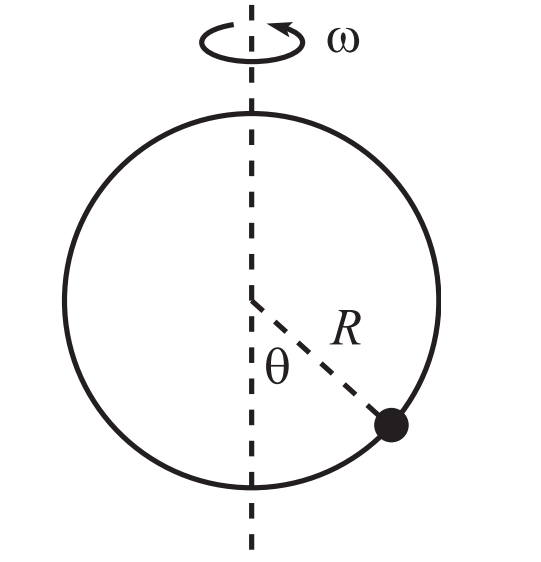

$$
\begin{align}

H &= \frac{p^{2}}{2mR^{2}} - \frac{1}{2} mR^{2} \omega^{2} \sin^{2}\theta - mgR \cos\theta \\
&= \frac{p^{2}}{2} - \frac{1}{2} \sin^{2}\theta - \cos\theta
\end{align}
$$
This gives us our equations of motion:
$$
\begin{align}
\frac{d\theta}{dt} &= \frac{\partial H}{\partial p} = p\\
\frac{dp}{dt} &= -\frac{\partial H}{\partial \theta} = \omega^2\sin\theta \cos\theta - \sin\theta
\end{align}
$$


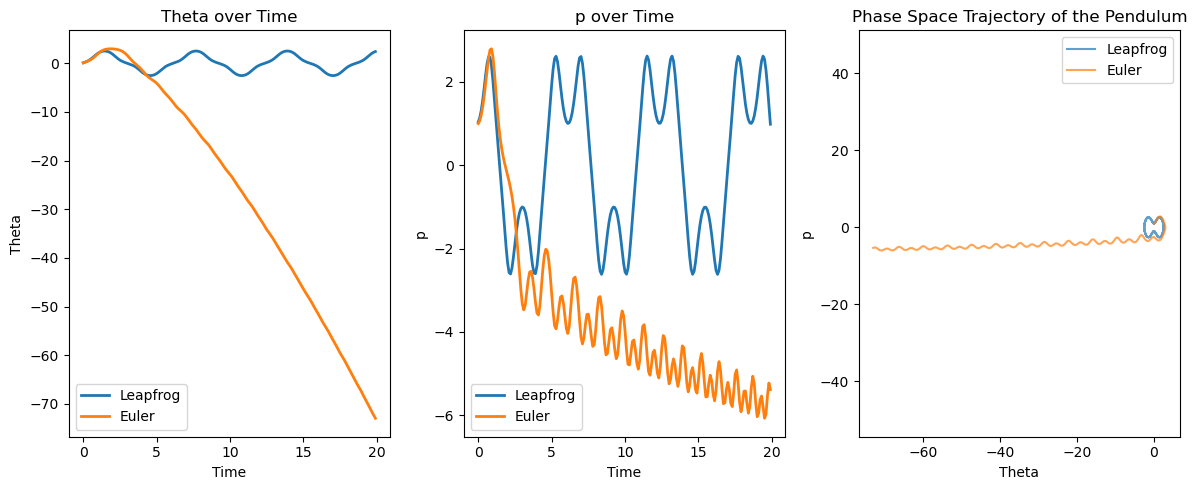

In [38]:
def theta_dot(p):
    return p

def p_dot(theta, omega=2.8):
    return omega**2 * np.sin(theta) * np.cos(theta) - np.sin(theta)

dt = 0.1
max_steps = 200

thetas_lf, ps_lf = leapfrog_history(np.array([0.0]), np.array([1.0]), dt, max_steps, theta_dot, p_dot)
thetas_eu, ps_eu = euler_history(np.array([0.0]), np.array([1.0]), dt, max_steps, theta_dot, p_dot)

# plot theta and p over time
time = np.arange(max_steps) * dt
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)

plt.plot(time, thetas_lf, label='Leapfrog', linewidth=2)
plt.plot(time, thetas_eu, label='Euler', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Theta')
plt.title('Theta over Time')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(time, ps_lf, label='Leapfrog', linewidth=2)
plt.plot(time, ps_eu, label='Euler', linewidth=2)
plt.xlabel('Time')
plt.ylabel('p')
plt.title('p over Time')
plt.legend()

# plot phase space
plt.subplot(1, 3, 3)
plt.plot(thetas_lf, ps_lf, label='Leapfrog', alpha=0.7)
plt.plot(thetas_eu, ps_eu, label='Euler', alpha=0.7)
plt.xlabel('Theta')
plt.ylabel('p')
plt.title('Phase Space Trajectory of the Pendulum')
plt.axis('equal')
plt.legend()
plt.tight_layout()



In [33]:
def leapfrog_history(q0, p0, q_dot, p_dot, num_steps):
    '''implementing the kick-drift-kick form separable hamiltonian'''
    
    dim = q0.shape[0]
    
    q_history = np.zeros((num_steps, dim))  # Include initial state
    p_history = np.zeros((num_steps, dim))

    q = q0.copy()
    p = p0.copy()

    for i in range(num_steps):

        p_half = p + 0.5 * dt * p_dot(q)

        q_new = q + dt * q_dot(p_half)

        p_new = p_half + 0.5 * dt * p_dot(q_new)

        # update values
        q = q_new
        p = p_new
        q_history[i] = q
        p_history[i] = p

    return q_history, p_history

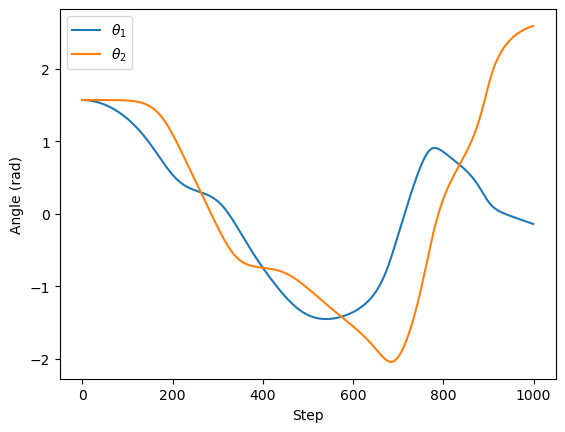

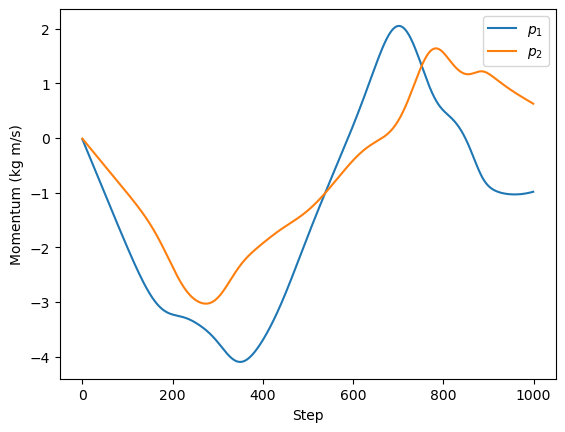

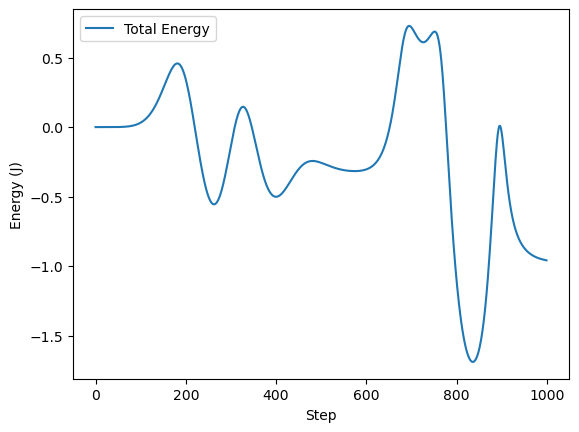

In [ ]:
def theta_dot(theta1, theta2, p1, p2):
    return p

def p_dot(theta1, theta2, p1, p2):
    dtheta = theta2 - theta1

    denom = 1 + np.sin(dtheta)**2
    
    # Gravity terms
    gravity1 = -2 * np.sin(theta1)
    gravity2 = -np.sin(theta2)
    
    # Coupling terms
    interaction = p1 * p2 * np.sin(dtheta) / denom
    
    # Nonlinear coupling from kinetic energy
    momentum_term = p1**2 + 2*p2**2 - 2*p1*p2*np.cos(dtheta)
    coupling = momentum_term * np.sin(2*dtheta) / (2 * denom**2)
    
    dp1_dt = gravity1 + interaction - coupling
    dp2_dt = gravity2 - interaction + coupling
    
    return dp1_dt, dp2_dt

theta1_0, theta2_0 = np.pi/2, np.pi/2  # initial angles
p1_0, p2_0 = 0.0, 0.0                 # initial momenta

dt = 0.01
steps = 1000

traj = leapfrog(theta1_0, theta2_0, p1_0, p2_0, dt, steps)

# Plot the angles
plt.plot(traj[:,0], label=r'$\theta_1$')
plt.plot(traj[:,1], label=r'$\theta_2$')
plt.xlabel('Step')
plt.ylabel('Angle (rad)')
plt.legend()
plt.show()

plt.figure()
plt.plot(traj[:,2], label=r'$p_1$')
plt.plot(traj[:,3], label=r'$p_2$')
plt.xlabel('Step')
plt.ylabel('Momentum (kg m/s)')
plt.legend()
plt.show()

def energy(theta1, theta2, p1, p2):
    dtheta = theta2 - theta1
    denom = 1 + np.cos(dtheta)**2
    
    # Kinetic energy with coupling
    T = (p1**2 + 2*p2**2 - 2*p1*p2*np.cos(dtheta)) / (2 * denom)
    
    # Potential energy
    V = -2*np.cos(theta1) - np.cos(theta2)
    
    return T + V

plt.figure()
plt.plot([energy(*state) for state in traj], label='Total Energy')
plt.xlabel('Step')
plt.ylabel('Energy (J)')
plt.legend()
plt.show()


This time we need to include another parameter in the integrator functions because we are no longer updating $x$ linearly, the function `B`.

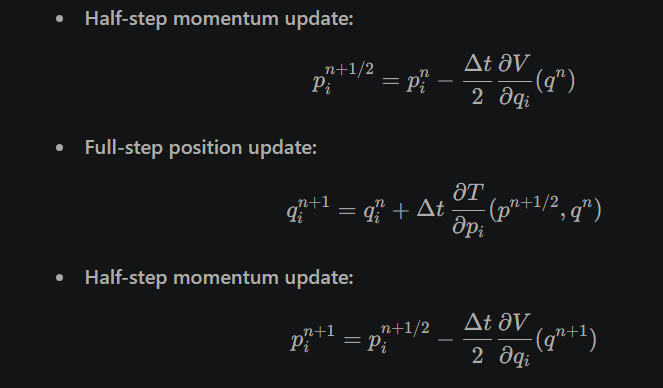

C:\Users\kaima\AppData\Local\Temp\ipykernel_48152\2013338195.py:21: RuntimeWarning: overflow encountered in scalar multiply
  dp1 = -2 * np.sin(theta1) + np.sin(dtheta) * (p1*p2 + p2**2 * np.cos(dtheta)) * denom
C:\Users\kaima\AppData\Local\Temp\ipykernel_48152\2013338195.py:21: RuntimeWarning: overflow encountered in scalar power
  dp1 = -2 * np.sin(theta1) + np.sin(dtheta) * (p1*p2 + p2**2 * np.cos(dtheta)) * denom
C:\Users\kaima\AppData\Local\Temp\ipykernel_48152\2013338195.py:21: RuntimeWarning: invalid value encountered in scalar add
  dp1 = -2 * np.sin(theta1) + np.sin(dtheta) * (p1*p2 + p2**2 * np.cos(dtheta)) * denom
C:\Users\kaima\AppData\Local\Temp\ipykernel_48152\2013338195.py:22: RuntimeWarning: overflow encountered in scalar multiply
  dp2 = -np.sin(theta2) - np.sin(dtheta) * (p1*p2 + p1**2 * np.cos(dtheta)) * denom
C:\Users\kaima\AppData\Local\Temp\ipykernel_48152\2013338195.py:22: RuntimeWarning: overflow encountered in scalar power
  dp2 = -np.sin(theta2) - np.sin(dthet

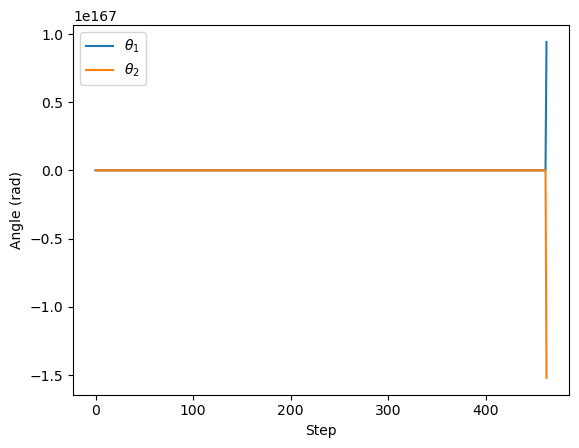

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Hamiltonian derivatives
# --------------------------
def theta_dot(theta1, theta2, p1, p2):
    dtheta = theta1 - theta2
    denom = 1 / (1 + np.sin(dtheta)**2)  # simplified factor for equal mass/length
    
    # velocity from canonical momenta
    theta1_dot = (p1 - p2 * np.cos(dtheta)) * denom
    theta2_dot = (2*p2 - p1 * np.cos(dtheta)) * denom
    return theta1_dot, theta2_dot

def p_dot(theta1, theta2, p1, p2):
    dtheta = theta1 - theta2
    denom = 1 / (1 + np.sin(dtheta)**2)

    # Gravity terms
    dp1 = -2 * np.sin(theta1) + np.sin(dtheta) * (p1*p2 + p2**2 * np.cos(dtheta)) * denom
    dp2 = -np.sin(theta2) - np.sin(dtheta) * (p1*p2 + p1**2 * np.cos(dtheta)) * denom

    return dp1, dp2

# --------------------------
# Leapfrog integrator
# --------------------------
def leapfrog(theta1, theta2, p1, p2, dt, steps):
    history = []
    for _ in range(steps):
        # Half-step momentum update
        dp1, dp2 = p_dot(theta1, theta2, p1, p2)
        p1 += 0.5 * dt * dp1
        p2 += 0.5 * dt * dp2
        
        # Full-step position update
        dtheta1, dtheta2 = theta_dot(theta1, theta2, p1, p2)
        theta1 += dt * dtheta1
        theta2 += dt * dtheta2
        
        # Another half-step momentum update
        dp1, dp2 = p_dot(theta1, theta2, p1, p2)
        p1 += 0.5 * dt * dp1
        p2 += 0.5 * dt * dp2
        
        history.append((theta1, theta2, p1, p2))
    return np.array(history)

# --------------------------
# Example simulation
# --------------------------
theta1_0, theta2_0 = np.pi/2, np.pi/2  # initial angles
p1_0, p2_0 = 0.0, 0.0                 # initial momenta

dt = 0.01
steps = 5000

traj = leapfrog(theta1_0, theta2_0, p1_0, p2_0, dt, steps)

# Plot the angles
plt.plot(traj[:,0], label=r'$\theta_1$')
plt.plot(traj[:,1], label=r'$\theta_2$')
plt.xlabel('Step')
plt.ylabel('Angle (rad)')
plt.legend()
plt.show()
